Naming Explanation :
XXXYYZZZ
XXX - ID number of a person who has done the signature. 
YY - Image sample number.
ZZZ - ID number of person whose signature is in photo.

Example: 
NFI-00602023 is an image of signature of person number 023 done by person 006. This is a forged signature.
NFI-02103021 is an image of signature of person number 021 done by person 021. This is a genuine signature.   

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
import git
repo = git.Repo('.', search_parent_directories=True)

In [4]:
#Define Path
forge_path = repo.working_tree_dir + "\\forge"
real_path = repo.working_tree_dir + "\\real"

In [20]:
#Preprocessing

def rgbToGray (img_path):
    img = cv2.imread(img_path , 0)
    return img

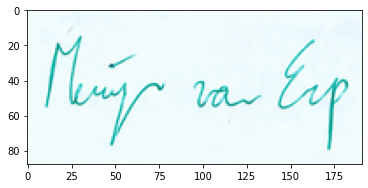

In [21]:
img_path = real_path + "\\00100001.png"
img = plt.imread(img_path)
plt.imshow(img)



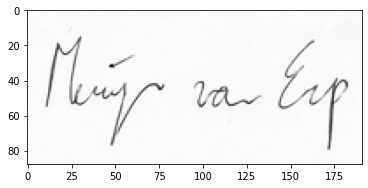

In [22]:
gray_img = rgbToGray(img_path)
plt.imshow(gray_img, cmap="Greys_r")